# Implementing a Deep CNN using PyTorch

In [ ]:
#input: grayscale images 28 * 28
#input tensor dimension = batchsize * 28 * 28 * 1
#1 means number of channels. It will be one for grayscale images
#input data goes through two conv. layers with kernel 5*5
#first conv layer: 32 output feature maps,
#Second conv layer: 64 output feature maps
#Each conv layer is followed by a subsampling layer int the form of a max-pooling operation.
#Then a fully-connected layer passes the output to a second fully connected layer which acts as final softmax output layer.

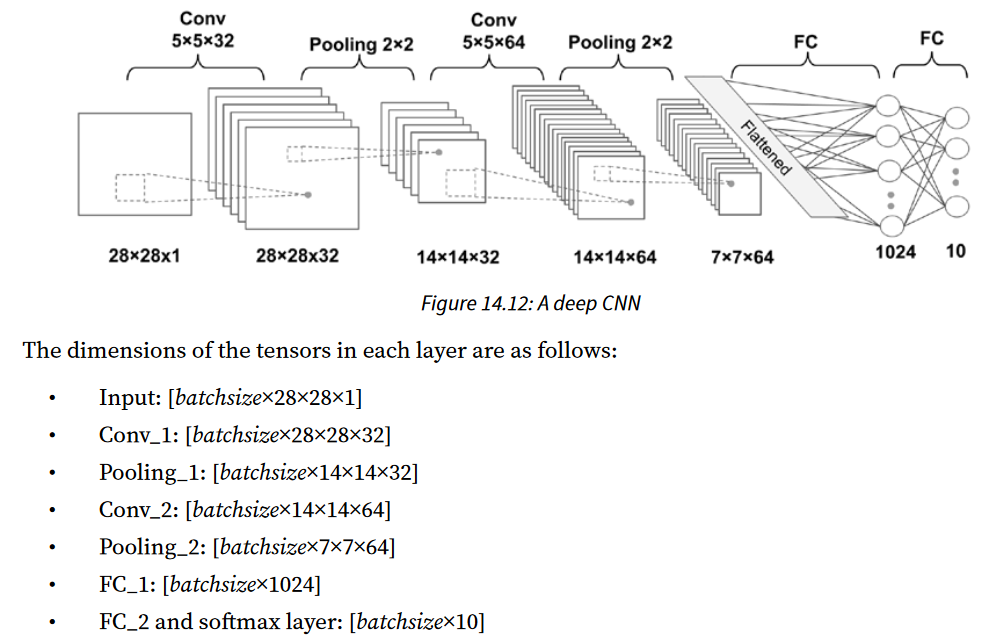

### Loading and Preprocessing the data

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
from torchvision import transforms

In [ ]:
image_path='/content/drive/MyDrive/MNIST'

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform = transform, download=False)

In [ ]:

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root = image_path, train=False, transform =transform, download = False)

In [ ]:
#Creating a Data loader with batches of 64 images for training set and validation set
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)
#images are already converted to tenstor using
#features we read are of values in the range [0,1]
#the labels are integers from 0 to 9

In [ ]:
#dataset preparation done

### Implementing a CNN using the torch.nn module

#### Configuring CNN layers in PyTorch
Constructing a layer with the Conv2d class requires us to specify the number of output channels (which
is equivalent to the number of output feature maps, or the number of output filters) and kernel sizes.
In addition, there are optional parameters that we can use to configure a convolutional layer. The
most commonly used ones are the strides (with a default value of 1 in both x, y dimensions) and pad-
ding, which controls the amount of implicit padding on both dimensions. Additional configuration
parameters are listed in the official documentation: https://pytorch.org/docs/stable/generated/
torch.nn.Conv2d.html.<br><br>
It is worth mentioning that usually, when we read an image, the default dimension for the channels
is the first dimension of the tensor array (or the second dimension considering the batch dimension).
This is called the NCHW format, where N stands for the number of images within the batch, C stands
for channels, and H and W stand for height and width, respectively.<br>
Note that the Conv2D class assumes that inputs are in NCHW format by default. (Other tools, such as
TensorFlow, use NHWC format.) However, if you come across some data whose channels are placed
at the last dimension, you would need to swap the axes in your data to move the channels to the first
dimension (or the second dimension considering the batch dimension). After the layer is constructed,
it can be called by providing a four-dimensional tensor, with the first dimension reserved for a batch
of examples; the second dimension corresponds to the channel; and the other two dimensions are
the spatial dimensions.<br><br>
As shown in the architecture of the CNN model that we want to build, each convolution layer is followed
by a pooling layer for subsampling (reducing the size of feature maps). The MaxPool2d and AvgPool2d
classes construct the max-pooling and average-pooling layers, respectively. The kernel_size argu-
ment determines the size of the window (or neighborhood) that will be used to compute the max or
mean operations. Furthermore, the stride parameter can be used to configure the pooling layer, as
we discussed earlier.
Finally, the Dropout class will construct the dropout layer for regularization, with the argument p that
denotes the drop probability pdrop, which is used to determine the probability of dropping the input
units during training, as we discussed earlier. When calling this layer, its behavior can be controlled
via model.train() and model.eval(), to specify whether this call will be made during training or
during the inference. When using dropout, alternating between these two modes is crucial to ensure
that it behaves correctly; for instance, nodes are only randomly dropped during training, not evalu-
ation or inference

### Constructing CNN in PyTorch

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2))
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))
#note: if the stride parameter is not defined then by default it is equal to the pooling kernel size

In [ ]:
x = torch.ones((4, 1, 28, 28))#example output for 4 images given as input
model(x).shape


torch.Size([4, 64, 7, 7])

In [ ]:
#The next layer that we want to add is a fully connected layer for implementing a classifier on top of our convolutional and
#pooling layers
#The input to this layer must have rank 2, that is shape[batch_size * input_units]
#Thus we need to flatten the output of the previous layers to meet this requirement for the fully connected layer
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [ ]:
#Now the input dimensions for the fully connected layer are correctly set up.
#Next we will add two fully connected layers with a dropout layer in between
model.add_module('fc1', nn.Linear(3136,1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
loss_fn = nn.CrossEntropyLoss()# the softmax is internally performed inside the loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#### Train

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()*y_batch.size(0)
      is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /=len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_valid[epoch] += is_correct.sum()
      loss_hist_valid[epoch] /=len(valid_dl.dataset)
      accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
      print(f'Epoch {epoch +1} accuracy: ' f'{accuracy_hist_train[epoch]:.4f} val_accuracy: ' f'{accuracy_hist_valid[epoch]:.4f}')
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [ ]:
#using designated settings for training model.train() and evaluation model.eval() will automatically set the mode for the dropout
#layer and rescale the hidden units appropriately so that we don not have to worry for the dropout layer and rescale the hidden
#units appropriately.

In [ ]:
#training the CNN module
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9488 val_accuracy: 0.9829
Epoch 2 accuracy: 0.9845 val_accuracy: 0.9876
Epoch 3 accuracy: 0.9887 val_accuracy: 0.9883
Epoch 4 accuracy: 0.9912 val_accuracy: 0.9886
Epoch 5 accuracy: 0.9929 val_accuracy: 0.9894
Epoch 6 accuracy: 0.9950 val_accuracy: 0.9906
Epoch 7 accuracy: 0.9951 val_accuracy: 0.9859
Epoch 8 accuracy: 0.9963 val_accuracy: 0.9893
Epoch 9 accuracy: 0.9960 val_accuracy: 0.9905
Epoch 10 accuracy: 0.9965 val_accuracy: 0.9903
Epoch 11 accuracy: 0.9975 val_accuracy: 0.9893
Epoch 12 accuracy: 0.9970 val_accuracy: 0.9913
Epoch 13 accuracy: 0.9972 val_accuracy: 0.9900
Epoch 14 accuracy: 0.9979 val_accuracy: 0.9906
Epoch 15 accuracy: 0.9986 val_accuracy: 0.9906
Epoch 16 accuracy: 0.9976 val_accuracy: 0.9894
Epoch 17 accuracy: 0.9975 val_accuracy: 0.9899
Epoch 18 accuracy: 0.9982 val_accuracy: 0.9907
Epoch 19 accuracy: 0.9984 val_accuracy: 0.9909
Epoch 20 accuracy: 0.9987 val_accuracy: 0.9908


In [47]:
import numpy as np

<function matplotlib.pyplot.show(close=None, block=None)>

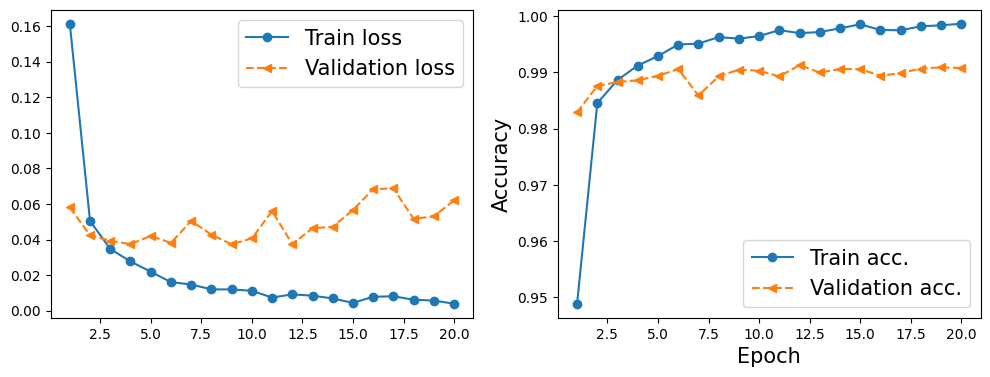

In [49]:
#visulaisation
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label ='Train acc.')
ax.plot(x_arr, hist[3], '--<', label = 'Validation acc.')
ax.legend(fontsize = 15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size = 15)
plt.show

In [50]:
pred = model(mnist_test_dataset.data.unsqueeze(1)/255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test Accuracy: {is_correct.mean():.4f}')

Test Accuracy: 0.9923


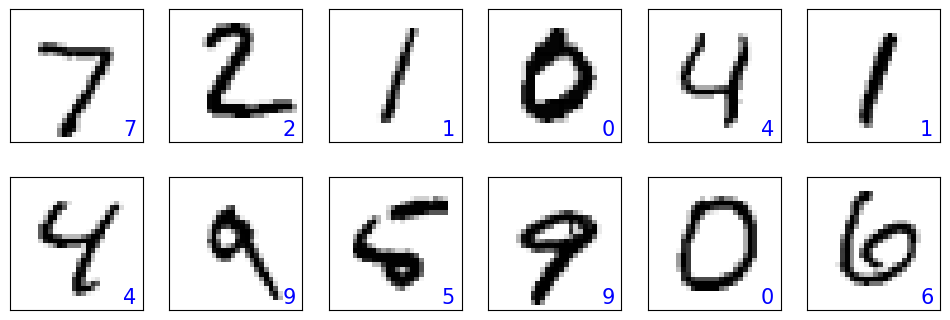

In [54]:
fig = plt.figure(figsize=(12,4))
for i in range(12):
  ax = fig.add_subplot(2, 6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test_dataset[i][0][0,:,:]
  pred = model(img.unsqueeze(0).unsqueeze(1))
  y_pred = torch.argmax(pred)
  ax.imshow(img, cmap = 'gray_r')
  ax.text(0.9, 0.1, y_pred.item(), size = 15, color = 'blue', horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
plt.show()